In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, ttest_ind
from matplotlib import pyplot as plt
# we used seborn 0.13.2
import seaborn as sns
from datetime import datetime
import dateutil

In [2]:
austin_zip = pd.read_csv("AustinZipCodes.csv")
austin_crime = pd.read_csv("crime-housing-austin-2015.csv")

Note: Throughout this notebook, we use 5% as the threshold for t-tests.

<Axes: xlabel='count', ylabel='Highest_NIBRS_UCR_Offense_Description'>

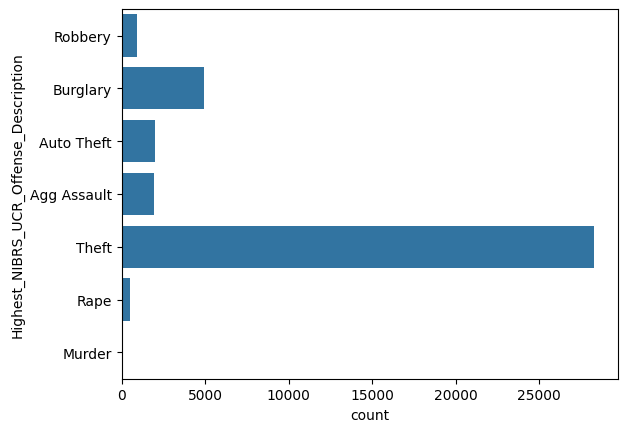

In [3]:
sns.countplot(austin_crime.Highest_NIBRS_UCR_Offense_Description)

### Finding Crimerate by District

In [4]:
austin_zip['Population'] = austin_zip['Population'].str.replace(',','').astype(int)

In [5]:
zip_code_crime = pd.merge(austin_crime, austin_zip, left_on="Zip_Code_Crime", right_on="Zip Code")

In [6]:
crime_by_district = zip_code_crime.groupby(["District",'Zip_Code_Crime']).agg({'Key':'size','Population':'mean'}).reset_index()
crime_by_district = crime_by_district.groupby("District").agg({'Key':'sum','Population':'sum'})

crime_by_district['crime_rate'] = crime_by_district.Key/crime_by_district.Population
crime_by_district = crime_by_district.reset_index()

In [7]:
crime_by_district

,District,Key,Population,crime_rate
0,A,3860,324055.0,0.011912
1,AP,177,1765.0,0.100283
2,B,4844,382907.0,0.012651
3,C,2906,124171.0,0.023403
4,D,5682,303751.0,0.018706
5,E,4937,265901.0,0.018567
6,F,4677,158185.0,0.029567
7,G,2709,45974.0,0.058925
8,H,3493,237755.0,0.014692
9,I,4306,338500.0,0.012721


[Text(0.5, 1.0, 'Crime Rate by District (excluding unknown)')]

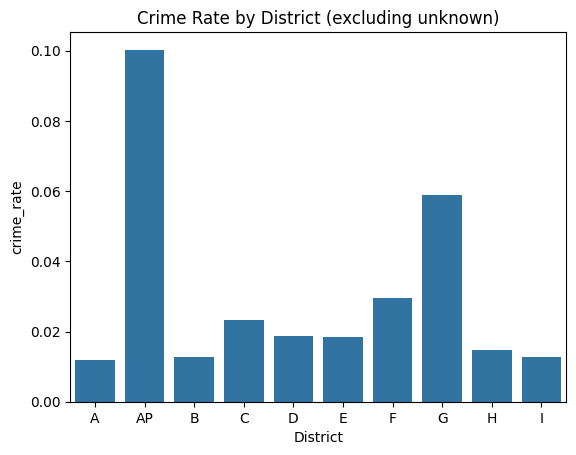

In [8]:
sns.barplot(data=crime_by_district, x="District", y="crime_rate").set(title="Crime Rate by District (excluding unknown)")

[Text(0.5, 1.0, 'Population by District (excluding unknown)')]

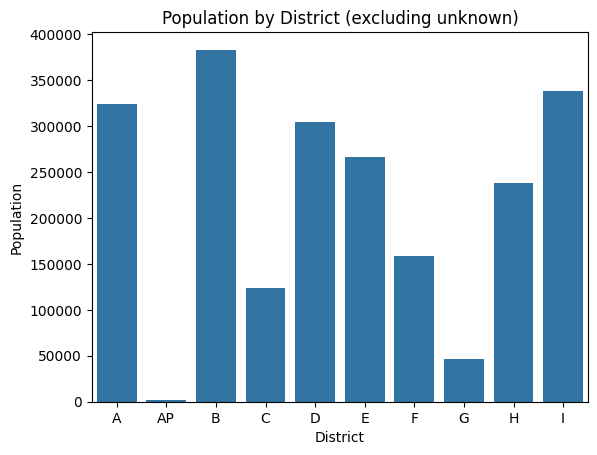

In [9]:
sns.barplot(data=crime_by_district, x="District", y="Population").set(title="Population by District (excluding unknown)")

Key Takeaways: 
- Airport has a high crimerate despite having a very small population. In fact, it likely has such a high crime rate because it has a small population.
- George also has a high crimerate and low population, possibly for the same reason. It also has the smallest area compared to the other districts.
- In contrast, Baker has the highest population, but the second lowest crimerate. Adam has the lowest crimerate.
- General trend seems to be that the higher the population, the lower the crimerate. 

[Text(0.5, 1.0, 'Crimerate vs Population')]

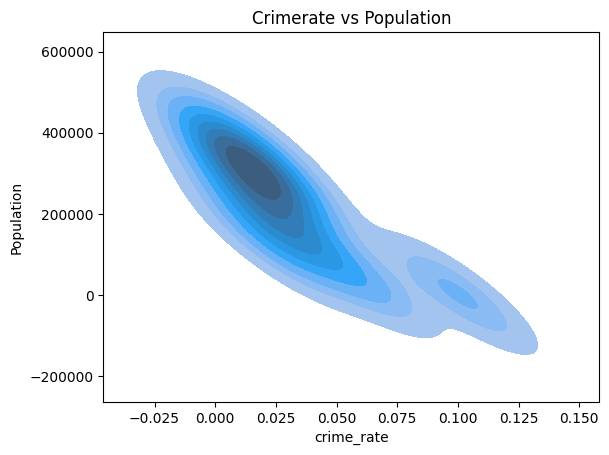

In [10]:
sns.kdeplot(data=crime_by_district, x="crime_rate", y="Population", fill=True).set(title="Crimerate vs Population")

We see that this the last bullet point appears to be true.

[Text(0.5, 1.0, 'Crimes in Airport')]

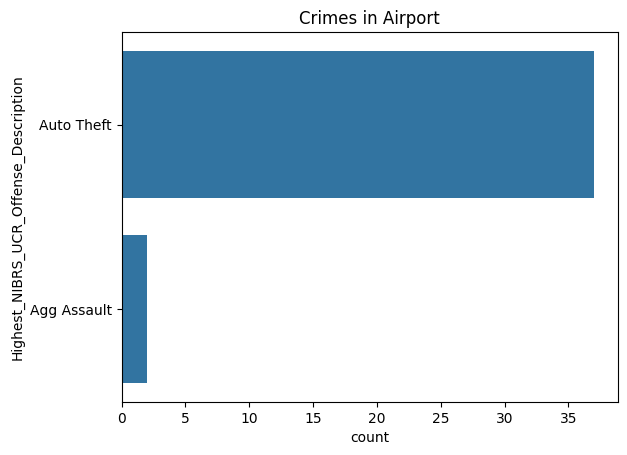

In [11]:
district_AP = austin_crime[austin_crime.District == "AP"]
district_AP_no_theft = district_AP[district_AP.Highest_NIBRS_UCR_Offense_Description != "Theft"]
sns.countplot(district_AP_no_theft.Highest_NIBRS_UCR_Offense_Description).set(title="Crimes in Airport")

[Text(0.5, 1.0, 'Crimes in George')]

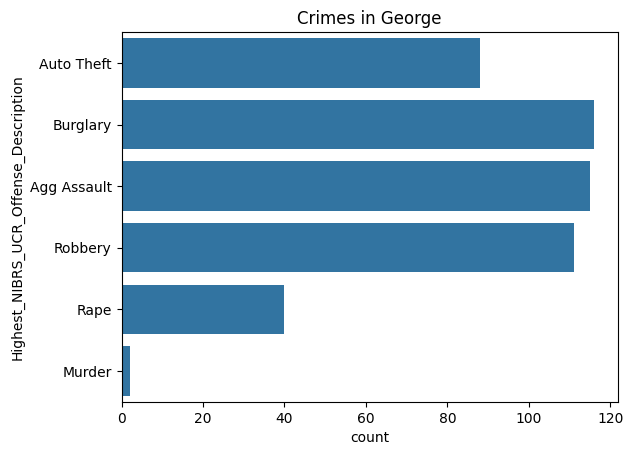

In [12]:
district_G = austin_crime[austin_crime.District == "G"]
district_G_no_theft = district_G[district_G.Highest_NIBRS_UCR_Offense_Description != "Theft"]
sns.countplot(district_G_no_theft.Highest_NIBRS_UCR_Offense_Description).set(title="Crimes in George")

[Text(0.5, 1.0, 'Crimes in Adam')]

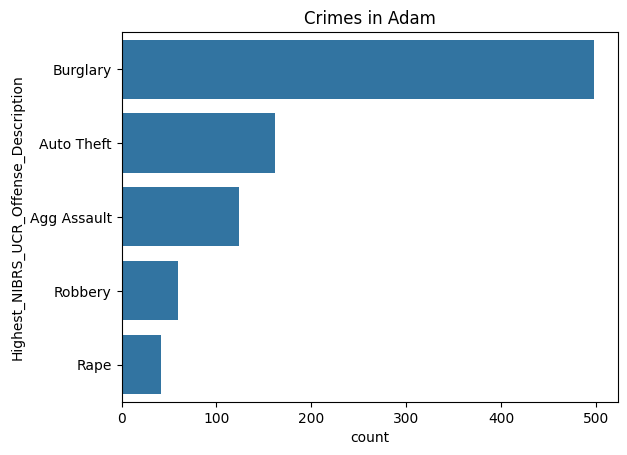

In [13]:
district_A = austin_crime[austin_crime.District == "A"]
district_A_no_theft = district_A[district_A.Highest_NIBRS_UCR_Offense_Description != "Theft"]
sns.countplot(district_A_no_theft.Highest_NIBRS_UCR_Offense_Description).set(title="Crimes in Adam")

### Compare Clearance Status with Report Period

Find Report Period (Difference Between Report Date and Clearance Date in Days)

In [14]:
def days_between(d1, d2):
    if d1 == "NA" or d2 == "NA":
        return -1
    d1 = datetime.strptime(d1, "%d-%m-%y")
    d2 = datetime.strptime(d2, "%d-%m-%y")
    return abs((d2 - d1).days)

months = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}

def convertDateMonth(raw_date):
    key = raw_date.split('-')[1]
    date = raw_date.replace(key, str(months[key]))
    return date

def report_period(reportDate, clearDate):
    if type(clearDate) == float:
        return -1
    rp_date = convertDateMonth(reportDate)
    cl_date = convertDateMonth(clearDate)
    return days_between(rp_date, cl_date)

austin_crime['report_period'] = austin_crime.apply(lambda x: report_period(x.Report_Date, x.Clearance_Date), axis=1)
austin_crime = austin_crime[austin_crime.report_period >= 0]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


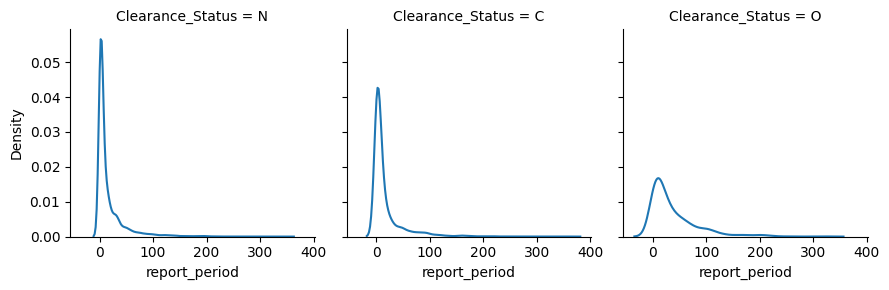

In [16]:
grid = sns.FacetGrid(austin_crime, col="Clearance_Status")
grid.map(sns.kdeplot, "report_period")

In [17]:
austin_crime.report_period.describe()

count    36649.000000
mean        17.549292
std         30.148283
min          0.000000
25%          2.000000
50%          5.000000
75%         19.000000
max        364.000000
Name: report_period, dtype: float64

In [18]:
status_N = austin_crime[austin_crime.Clearance_Status == "N"]
status_C = austin_crime[austin_crime.Clearance_Status == "C"]
status_O = austin_crime[austin_crime.Clearance_Status == "O"]

In [19]:
ttest_ind(status_N.report_period, status_O.report_period)

TtestResult(statistic=-21.559734739006302, pvalue=2.373821758471683e-102, df=31402.0)

-> Key Takeaway: On average, the clearance status O takes more time to process than status N.

### Compare Report Period by District

<Axes: xlabel='count', ylabel='District'>

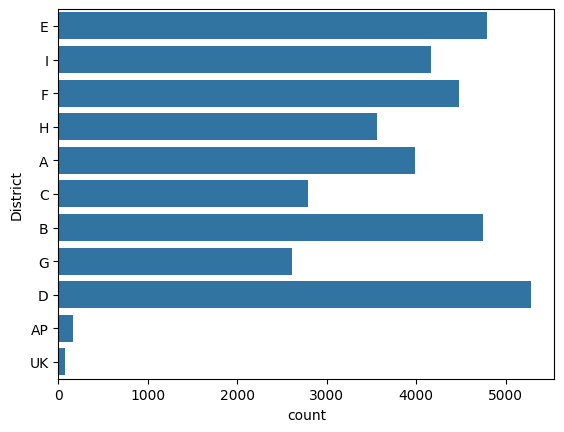

In [20]:
sns.countplot(austin_crime["District"], label = )

David has the most crimes committed and George has the least by raw numbers.

Good to remember however that George had the highest crimerate and Adam had the lowest crimerate.

### Is there a difference between George's and David's Report Period?

In [21]:
district_D = austin_crime[austin_crime.District == "D"]
district_G = austin_crime[austin_crime.District == "G"]

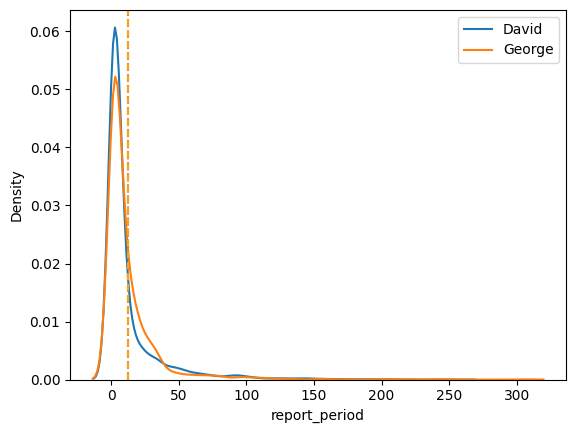

In [22]:
sns.kdeplot(district_D.report_period, label="David")
sns.kdeplot(district_G.report_period, label="George")

plt.axvline(x=district_D.report_period.mean(), color='blue', ls='--')
plt.axvline(x=district_G.report_period.mean(), color='orange', ls='--')

plt.legend()

In [23]:
ttest_ind(district_D.report_period, district_G.report_period)

TtestResult(statistic=-0.09985055507627259, pvalue=0.920465507919932, df=7891.0)

Key Takeaway: No! Very unlikely there's actually a difference in report periods for George and .

### Is there a difference between George's and Adam's Report Period?

In [24]:
district_A = austin_crime[austin_crime.District == "A"]

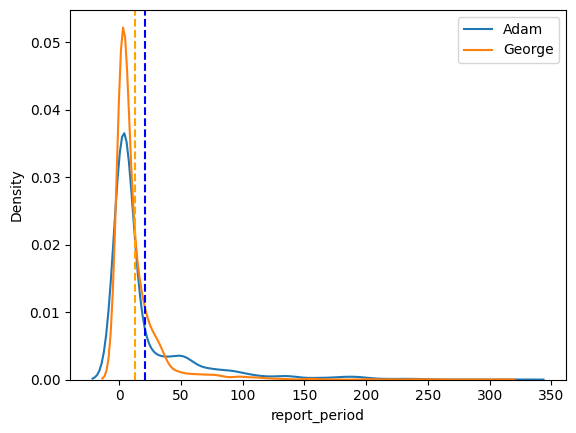

In [25]:
sns.kdeplot(district_A.report_period, label="Adam")
sns.kdeplot(district_G.report_period, label="George")

plt.axvline(x=district_A.report_period.mean(),color='blue',ls='--')
plt.axvline(x=district_G.report_period.mean(),color='orange',ls='--')

plt.legend()

In [26]:
ttest_ind(district_A.report_period, district_G.report_period)

TtestResult(statistic=10.506855704840483, pvalue=1.2783829861089084e-25, df=6602.0)

Key Takeaway: There is a statistical significance between Adam and George, so it is less likely their report periods' are different by chance.

### Comparing Report Period by Crime Committed

In [27]:
crime_types = list(austin_crime.Highest_NIBRS_UCR_Offense_Description.unique())
crime_types

['Robbery', 'Burglary', 'Auto Theft', 'Agg Assault', 'Theft', 'Rape', 'Murder']

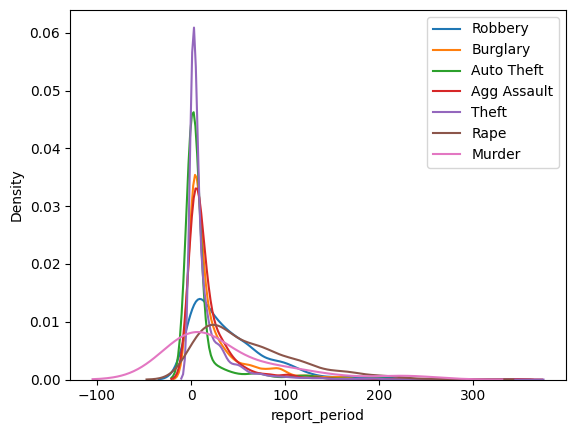

In [28]:
for data in crime_types:
    sns.kdeplot(austin_crime[austin_crime.Highest_NIBRS_UCR_Offense_Description == data].report_period,label=data)
    plt.legend()

Murders take the longest to clear, while thefts take the least time. Is this statistically significant?

In [29]:
murders = austin_crime[austin_crime.Highest_NIBRS_UCR_Offense_Description == "Murder"]
thefts = austin_crime[austin_crime.Highest_NIBRS_UCR_Offense_Description == "Theft"]

In [30]:
ttest_ind(murders.report_period, thefts.report_period)

TtestResult(statistic=3.5569592127422425, pvalue=0.0003758220995827882, df=26689.0)

Key takeaway: Fairly significant, showing that it's unlikely the difference of report periods between Theft and Murder is by chance.